# Module 7: Taking Everything Together with Use Cases

## <span style="color:darkblue">Creating Tables of Interest using ```psycopg2``` in Python </span> 

<font size="5">

- We are using two main libraries: 

    1. Pyscopg2 to connect with SQL ([here](https://www.psycopg.org/docs/) is the documentation)

    2. sqlio to run SQL queries directly using Pandas ([here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql_query.html) is the documentation)

In [1]:
import psycopg2
import pandas.io.sql as sqlio

<font size="5">

- The first step is to create a connection between Python and our local Formula 1 database 

In [2]:
con = psycopg2.connect(
    host = 'localhost',
    database = 'formula1',
    user = 'postgres',
    password  = '1nf1n1t0')

<font size="5">

- Assume we want to create a table with the total points for each driver and read it directly with Pandas

- In lecture 21, we use the following SQL query to create that table:

```sql
    SELECT driverid, SUM(points) AS total_points 
    FROM f1_tables.results
    GROUP BY driverid
    ORDER BY total_points DESC
```

- we can use psycopg2 and sqlio to execute the query and save the result in a pandas DataFrame directly

1. Save the string of the query in a Python object 

In [17]:
points_query = ("SELECT driverid, SUM(points) AS total_points \
                FROM f1_tables.results \
                GROUP BY driverid \
                ORDER BY total_points DESC;")

points = sqlio.read_sql_query(points_query, con)

d:\Users\JuanEstrada\anaconda3\envs\qtm151\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<font size="5">

- With the new table, we could create exploratory plots

- Let's create a boxplot to explore the distribution of points across drivers

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Distribution of points across drivers')

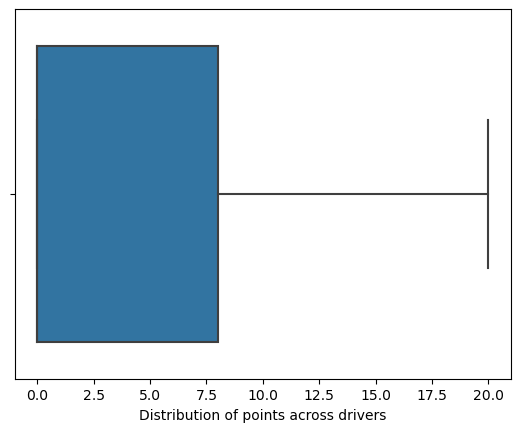

In [14]:
fig, ax = plt.subplots() 
sns.boxplot(data=points, x='total_points', showfliers = False)
ax.set_xlabel('Distribution of points across drivers')

<AxesSubplot:xlabel='total_points'>

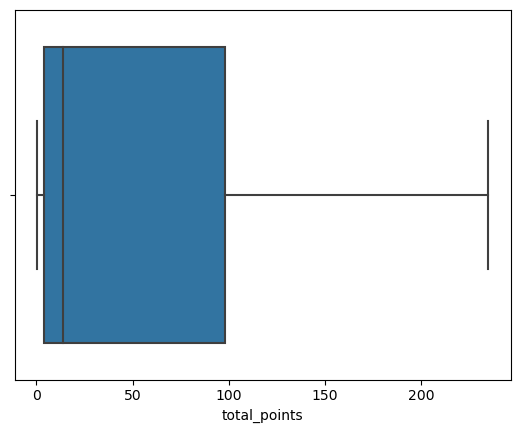

In [16]:
sns.boxplot(data=points[points['total_points']>0], x='total_points', showfliers = False)

<font size="5">

- What if we want to see the distribution of points by drivers' country of origin?

- We can use the SQL functions ```WITH``` and ```AS``` to use the result of a query as a table without having to create a new table in the database 

- If we want to match the points table with the drivers table, we can use the following query:

```sql
    WITH total_points_table AS (
        SELECT driverid, SUM(points) AS total_points 
        FROM f1_tables.results 
        GROUP BY driverid 
        ORDER BY total_points DESC)

    SELECT total_points_table.driverid, forename, surname, nationality, total_points
    FROM total_points_table 
    LEFT JOIN f1_tables.drivers
    ON total_points_table.driverid = drivers.driverid
```

<font size="5">

- We can use that query directly with sqlio to create a Pandas DataFrame

In [20]:
points_nationality_query = ("WITH total_points_table AS \
                            (SELECT driverid, SUM(points) AS total_points \
                            FROM f1_tables.results \
                            GROUP BY driverid  \
                            ORDER BY total_points DESC) \
                            SELECT total_points_table.driverid, forename, surname, nationality, total_points \
                            FROM total_points_table \
                            LEFT JOIN f1_tables.drivers \
                            ON total_points_table.driverid = drivers.driverid;")

points_nationality = sqlio.read_sql_query(points_nationality_query, con)

d:\Users\JuanEstrada\anaconda3\envs\qtm151\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [21]:
points_nationality

,driverid,forename,surname,nationality,total_points
0,1,Lewis,Hamilton,British,4308.5
1,2,Nick,Heidfeld,German,259.0
2,3,Nico,Rosberg,German,1594.5
3,4,Fernando,Alonso,Spanish,2021.0
4,5,Heikki,Kovalainen,Finnish,105.0
...,...,...,...,...,...
849,851,Jack,Aitken,British,0.0
850,852,Yuki,Tsunoda,Japanese,43.0
851,853,Nikita,Mazepin,Russian,0.0
852,854,Mick,Schumacher,German,12.0


<font size="5">

- Let's now create a series of boxplots by Nationality

In [32]:
nl = list(points_nationality[['nationality', 'total_points']].groupby('nationality', as_index=False).sum().sort_values(
                                                            by='total_points', ascending=False)['nationality'])

In [37]:
points_plot = points_nationality[points_nationality['nationality'].isin(nl[0:5])]

<AxesSubplot:xlabel='total_points', ylabel='nationality'>

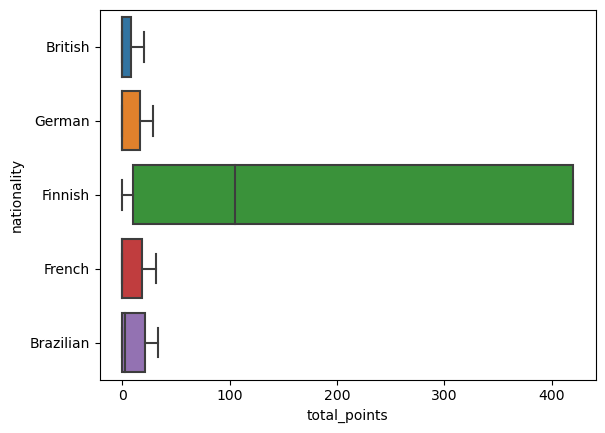

In [38]:
fig, ax = plt.subplots() 
sns.boxplot(data=points_plot, x='total_points', y = 'nationality', showfliers = False)